From https://www.sciencedirect.com/science/article/pii/S030440762100227X#appSB

# Scalable Inference for stochastic volatility.
## Implementation of the Feynman Kac model describing the transition dynamics in the above paper

In [1]:
import jax
import jax.numpy as jnp
import jax.random as jr
import jax.tree_util as jtu
from jax import Array, jit, lax, vmap
from jax.scipy.stats import multivariate_normal, norm

import matplotlib.pyplot as plt

from dynamax.linear_gaussian_ssm import (
    lgssm_filter,
    lgssm_smoother,
    LinearGaussianSSM as dmax_LGSSM,
)

from feynman_kac.protocol import FeynmacKac, PFConfig, PFOutputs, CSMC
from feynman_kac.bootstrap import BootstrapParticleFilter
from feynman_kac.utils import log_normalize, ess

from resample.resamplers import RESAMPLERS, single_multinomial, multinomial_resample

from model.lgssm import LGSSMModel
from utils.datasets import load_dataset


In [2]:
def find_temper_delta(log_w_norm, log_g_t, beta, ess_target):
    left, right = 1e-3, 1.0 - beta

    def ess_at(delta):
        lw_new = log_w_norm + delta * log_g_t
        lw_new -= jax.nn.logsumexp(lw_new)
        return ess(jnp.exp(lw_new)), lw_new

    def bisect(_):
        def cond(carry):
            l, r = carry
            return (r - l) > 1e-4

        def body(carry):
            l, r = carry
            mid = 0.5 * (l + r)
            ess_mid, _ = ess_at(mid)
            # ESS decreases with delta
            l = jnp.where(ess_mid > ess_target, mid, l)   # ESS too high → increase Δβ
            r = jnp.where(ess_mid <= ess_target, mid, r)  # ESS too low → shrink Δβ
            return (l, r)

        l, r = jax.lax.while_loop(cond, body, (left, right))
        return 0.5 * (l + r)

    ess_left, _ = ess_at(left)
    ess_right, _ = ess_at(right)

    # jax.debug.print("[ESS] left={}, right={}", ess_left, ess_right)

    # handle edge cases based on monotonic ESS
    delta = jax.lax.cond(
        ess_target >= ess_left,      # target ESS higher than achievable (Δβ=0)
        lambda _: left,
        lambda _: jax.lax.cond(
            ess_target <= ess_right,  # target ESS too low (Δβ=max)
            lambda _: right,
            lambda _: bisect(_),
            operand=None
        ),
        operand=None
    )

    ess_val, lw_new = ess_at(delta)
    return delta, ess_val, lw_new

    
def _gather(x, idx):
    return jtu.tree_map(lambda a: a[idx], x)


In [3]:
class TemperedBPF:
    """
    The Bootstrap PF takes the potential function as the emission likelihood,
    and the Markov transition kernel as the proposal distribution. Unlike a guided PF,
    the Bootstrap PF cannot use lookahead information from the observations when proposing particles.
    """

    def __init__(self, model: FeynmacKac, config: PFConfig):
        self.model = model
        self.cfg = config
        self.key = config.key
        self.resampler = RESAMPLERS[config.resample_scheme]

        self.vmapped_pt = vmap(lambda key, x, t: self.model.pt(key, x, t), in_axes=(0, 0, None))
        self.vmapped_log_g = vmap(self.model.log_g, in_axes=(None, 0, 0, None))
        self.vmapped_log_pt = vmap(self.model.log_pt, in_axes=(None, 0, 0))
        
    def filter(self, key: jr.PRNGKey, T: int, obs: Array) -> PFOutputs:
        """
        """

        N = self.cfg.N
        ess_min = self.cfg.ess_threshold * N if self.cfg.ess_threshold is not None else jnp.inf    

        # t = 0 
        key0, key = jr.split(key)
        x_n0, log_wn0, norm_w_n0, logZ_0 = self.t0(key0, N, obs[0])

        def step(carry, obs_t):
            
            key, x_n_prev, log_wn_prev, norm_wn_prev, logZ_prev = carry
            key1, key2 = jr.split(key)
            t, y_t = obs_t

            # jax.debug.print("[step] t={}", t)

            # sample transition
            keys_t = jr.split(key1, N)
            x_nt = self.vmapped_pt(keys_t, x_n_prev, t)  # (N,d)
            
            # tempering (does resampling and weight calculation)
            key_temper, x_nt, log_wnt, idx = self.temper(
                key2,           # RNG
                x_nt,           # current particles
                x_n_prev,       # previous particles
                t,              # time index
                y_t,            # observation
                ess_min,        # ESS threshold
                N,              # number of particles
            )
            
            w_nt_norm, logZ_t = log_normalize(log_wnt)
            logZ = logZ_prev + logZ_t
            
            # track ESS and resampling index (dummy idx here, since temper handles resampling internally)
            ess_t = ess(w_nt_norm)
            
            return (key_temper, x_nt, log_wnt, w_nt_norm, logZ), (
                x_nt,
                w_nt_norm,
                idx,
                ess_t,
            )
        
        obs = (jnp.arange(1, T), obs[1:])
        carry0 = (key, x_n0, log_wn0, norm_w_n0, logZ_0)
        (key, _, _, w_nT_norm, logZ_hat), (particles, weights, ancestors, ess_hist) = lax.scan(step, carry0, obs)

        # prepend t=0
        particles = jtu.tree_map(
            lambda x0, xT: jnp.concatenate([x0[None, ...], xT], axis=0),
            x_n0, particles
        )                                                                               # (T+1, N, d)
        weights = jnp.concatenate([norm_w_n0[None, ...], weights], axis=0)              # (T+1, N)
        ess_hist = jnp.concatenate([ess_hist, jnp.array([ess(w_nT_norm)])], axis=0)     # (T+1,)

        self.key = key

        return PFOutputs(
            particles=particles,
            weights=weights,
            ancestors=ancestors,
            logZ_hat=logZ_hat,
            ess_history=ess_hist,
        )
    
    def t0(self, key: jr.PRNGKey, N, obs0: Array):
        
        x_n0 = self.model.p0(key, N)  # (N,d)
        log_wn0 = self.vmapped_log_g(0, x_n0, None, obs0)  # (N,)
        norm_w_n0, logZ_0 = log_normalize(log_wn0)
        
        return x_n0, log_wn0, norm_w_n0, logZ_0
    
    def resample(self, key, N, norm_wn_prev, ess_min, x_n_prev, log_wn_prev):
        def do_resample(_):
            idx = self.resampler(key, norm_wn_prev)
            x_res = _gather(x_n_prev, idx)
            return x_res, jnp.zeros(N), idx
        
        def skip_resample(_):
            return x_n_prev, log_wn_prev, jnp.arange(N)
        
        ess_t = ess(norm_wn_prev)
        x_n_prev, log_wn_prev, idx = lax.cond(
            ess_t < ess_min,
            do_resample,
            skip_resample,
            operand=None
        )
        return x_n_prev, log_wn_prev, idx, ess_t
    
    def temper(self, key, x_nt, x_n_prev, t, y_t, ess_min, N):
        """
        
        1. Sample x_nt_b as x_nt_b | x_nb_prev ~ N(A @ x_nb_prev, Q / b). If b=0 use x_n_prev.
        2. Calculate tempered log potentials (beta @ log_g_curr) using x_nt_b and y_t. 
        3. If ESS < ESS_min: resample.
        4. Repeat until b = 1

        TODOs:
         - correct the doc string above
         - correct the lineage tracking through MCMC mutations and resampling.
        """

        beta = 0.0
        x_nt_b = x_nt

        # start with weights 1/N
        norm_wb = jnp.ones(N) / N
        log_wb = jnp.log(norm_wb) 
        log_g_curr = self.vmapped_log_g(t, x_nt_b, x_n_prev, y_t)
        log_pt_curr = self.vmapped_log_pt(t, x_nt_b, x_n_prev)
        
        def cond(carry):
            beta, *_ = carry
            return beta < 1.0 - 1e-5

        def step(carry):
            
            beta, key, x_nt_b, log_wb_prev, log_g_curr, log_pt_curr, _ = carry

            # 1. Find delta temperature
            delta, _, _ = find_temper_delta(log_wb_prev, log_g_curr, beta, ess_min)
            delta = jnp.minimum(delta, 1.0 - beta)
            beta = beta + delta

            # jax.debug.print("[temperature] beta={}", beta)

            # 2. Compute new weights
            # log_g_curr = self.vmapped_log_g(t, x_nt_b, x_n_prev, y_t)
            # log_pt_curr = self.vmapped_log_pt(t, x_nt_b, x_n_prev)
            log_wb = log_wb_prev + (delta * log_g_curr)
            norm_wb, _ = log_normalize(log_wb)

            # 3. Potentially resample
            key, subkey = jr.split(key)
            x_nb_res, log_wb, idx, ess_tb = self.resample(
                subkey, N, norm_wb, ess_min, x_nt_b, log_wb
            )
            log_g_curr = log_g_curr[idx]
            log_pt_curr = log_pt_curr[idx]

            # 4. Gaussian local proposal
            key, key_norm, key_unif = jr.split(key, 3)
            # noise = 0.1 * jr.normal(key_norm, shape=x_nb_res.shape)
            # x_nt_b_prop = x_nb_res + noise
            noise = jtu.tree_map(lambda x: 0.1 * jr.normal(key_norm, shape=x.shape), x_nb_res)
            x_nt_b_prop = jtu.tree_map(lambda x, n: x + n, x_nb_res, noise)

            # 5. Calculate acceptances for proposals
            log_g_prop = self.vmapped_log_g(t, x_nt_b_prop, x_n_prev, y_t)
            log_pt_prop = self.vmapped_log_pt(t, x_nt_b_prop, x_n_prev)

            # unif_n = jr.uniform(key_unif, shape=(x_nt_b.shape[0], ))
            # logA = beta * (log_g_prop - log_g_curr) + (log_pt_prop - log_pt_curr)
            # alpha = jnp.minimum(1.0, jnp.exp(logA))
            # accept = unif_n <= alpha

            # # update x and log potentials to reflect acceptances
            # x_nb_next  = jnp.where(accept[:, None], x_nt_b_prop, x_nb_res)
            # log_g_next  = jnp.where(accept, log_g_prop, log_g_curr)
            # log_pt_next  = jnp.where(accept, log_pt_prop, log_pt_curr)

            unif_n = jr.uniform(key_unif, shape=(jtu.tree_leaves(x_nt_b)[0].shape[0],))
            logA = beta * (log_g_prop - log_g_curr) + (log_pt_prop - log_pt_curr)
            alpha = jnp.minimum(1.0, jnp.exp(logA))
            accept = unif_n <= alpha  # (N,)
            
            # pytree-safe updates
            def select_branch(x_prop, x_old):
                # broadcast accept over trailing dims of each array
                mask = accept
                while mask.ndim < x_prop.ndim:
                    mask = mask[..., None]
                return jnp.where(mask, x_prop, x_old)
            
            x_nb_next = jtu.tree_map(select_branch, x_nt_b_prop, x_nb_res)
            log_g_next = jnp.where(accept, log_g_prop, log_g_curr)
            log_pt_next = jnp.where(accept, log_pt_prop, log_pt_curr)
                
            # # reset weights
            # norm_wb = jnp.ones(N) / N
            # log_wb = jnp.log(norm_wb)
            
            return (beta, key, x_nb_next, log_wb, log_g_next, log_pt_next, idx)

        # run the temper scan
        beta, key, x_nt, log_wb, _, _, idx = jax.lax.while_loop(
            cond,
            step,
            (beta, key, x_nt_b, log_wb, log_g_curr, log_pt_curr, jnp.arange(N))
        )
        return key, x_nt, log_wb, idx

    def smooth(self, key: jr.PRNGKey, T: int, obs: Array):
        """
        Backward-sampling smoother returning N smoothed trajectories.
        Handles particles as arrays or PyTrees.
        """
        outs = self.filter(key, T, obs)
        particles = outs.particles      # PyTree or Array: (T, N, D)
        weights = outs.weights          # (T, N)
        
        N = weights.shape[1]
        
        def single_smoother(subkey):
            """Sample one trajectory."""
            key = subkey
            B = jnp.zeros((T,), dtype=jnp.int32)
            w_hist = jnp.zeros((T, N))
            
            # 1. Final index from filtering weights
            key, key_final = jr.split(key)
            B = B.at[T - 1].set(jnp.squeeze(single_multinomial(key_final, weights[-1])))
            w_hist = w_hist.at[T-1].set(weights[T-1])
    
            # vectorized log transition
            def log_pt_t(t, x_t, x_prev):
                return self.model.log_pt(t, x_t, x_prev)
    
            log_pt = vmap(lambda t, x_t, x_prev: log_pt_t(t, x_t, x_prev), in_axes=(None, None, 0))
    
            # backward recursion
            def step(carry, t):
                key, B, w_hist = carry
                key, subkey = jr.split(key)
                idx = T - 1 - t
                x_next = jtu.tree_map(lambda p: p[idx + 1, B[idx + 1]], particles)
                x_nt = jtu.tree_map(lambda p: p[idx], particles)
    
                log_W_tilde = jnp.log(weights[idx] + 1e-30) + log_pt(idx + 1, x_next, x_nt)
                W_tilde, _ = log_normalize(log_W_tilde)
                B = B.at[idx].set(jnp.squeeze(single_multinomial(subkey, W_tilde)))
                w_hist = w_hist.at[idx].set(W_tilde)
                return (key, B, w_hist), None
    
            (key, B, w_hist), _ = lax.scan(step, (key, B, w_hist), jnp.arange(1, T))
    
            # extract smoothed trajectory
            smoothed = jtu.tree_map(lambda p: p[jnp.arange(T), B], particles)
            return smoothed, w_hist 
    
        # split keys for each smoother
        keys = jr.split(key, N)
        smoothed, w_smooth = vmap(single_smoother)(keys)
        smoothed = jtu.tree_map(lambda p: jnp.swapaxes(p, 0, 1), smoothed)
    
        # normalize smoothing weights
        w_smooth  = jnp.swapaxes(w_smooth, 0, 1) 
    
        return PFOutputs(
            particles=smoothed,
            weights=w_smooth,
            ancestors=outs.ancestors,
            logZ_hat=outs.logZ_hat,
            ess_history=outs.ess_history,
        )

    # def smooth(self, key: jr.PRNGKey, T: int, obs: Array):
    #     """
    #     1. Get filtered particles.
    #     2. Perform backward sampling on the given particles and weights.
    #     """
        
    #     outs = self.filter(key, T, obs)
    #     particles = outs.particles
    #     weights = outs.weights

    #     N = weights.shape[1]
    #     B = jnp.zeros((T, N), dtype=jnp.int32)
    #     B = B.at[T - 1].set(jnp.squeeze(multinomial_resample(key, weights[-1])))

    #     log_pt = vmap(
    #         vmap(
    #             lambda t, x_t, x_prev: self.model.log_pt(t, x_t, x_prev),
    #             in_axes=(None, None, 0),
    #         ),
    #         in_axes=(None, 0, None)
    #     )
        
    #     def step(carry, t):
    #         key, B = carry
    #         key, subkey = jr.split(key)
    #         idx = T - 1 - t  # reverse index
            
    #         # sample ancestors
    #         # x_next = particles[idx + 1, B[idx + 1]]
    #         # x_nt = particles[idx]
    #         x_next = jtu.tree_map(lambda p: p[idx + 1, B[idx + 1]], particles)
    #         x_nt = jtu.tree_map(lambda p: p[idx], particles)
            
    #         log_W_tilde = jnp.log(weights[idx] + 1e-30) + log_pt(idx + 1, x_next, x_nt)
    #         W_tilde, _ = vmap(lambda log_w: log_normalize(log_w))(log_W_tilde)
    #         jax.debug.print("[Weights], W_tilde shape: {}", W_tilde.shape)

    #         keys = jr.split(subkey, N)
    #         new_idx = vmap(lambda k, w: jnp.squeeze(single_multinomial(k, w)))(keys, W_tilde)
    #         B = B.at[idx].set(new_idx)
            
    #         # B = B.at[idx].set(jnp.squeeze(multinomial_resample(subkey, W_tilde)))
    #         return (key, B), None

    #     carry = (key, B)
    #     (key, B), _ = lax.scan(step, carry, jnp.arange(1, T))
    #     smoothed = jtu.tree_map(lambda p: p[jnp.arange(T), B], particles)
        
    #     return PFOutputs(
    #         particles=smoothed,
    #         weights=weights,
    #         ancestors=outs.ancestors,
    #         logZ_hat=outs.logZ_hat,
    #         ess_history=outs.ess_history,
    #     )


In [4]:

def givens_rotation(D, i, j, omega):
    """
    Create an n x n Givens rotation matrix that rotates in the (i, j) plane.

    Parameters:
        D (int): Dimension of the square matrix.
        i (int): First index (0-based).
        j (int): Second index (0-based).
        omega (float): Rotation angle in radians.

    Returns:
        jnp.ndarray: Givens rotation matrix.
    """
    
    # Start with identity
    G = jnp.eye(D)
    c = jnp.cos(omega)
    s = jnp.sin(omega)

    # Apply rotation in (i, j) plane
    G = G.at[i, i].set(c)
    G = G.at[j, j].set(c)
    G = G.at[i, j].set(s)
    G = G.at[j, i].set(-s)

    return G


@jit
def givens_product(w_ij: Array):
    """
    w_ij: (D, D) angles; we use only strict upper-triangle (i<j).
    
    Returns:
        P: (D, D) product G_{(0)} @ G_{(1)} @ ... @ G_{(M-1)}
    """
    
    D = w_ij.shape[0]
    i_idx, j_idx = jnp.triu_indices(D, k=1)          # vectors of length M
    omegas = w_ij[i_idx, j_idx]                       # (M,)

    # construct Givens matrices over all (i,j,omega)
    G_all = vmap(
        lambda ii, jj, om: givens_rotation(D, ii, jj, om),
        in_axes=(0, 0, 0)
    )(i_idx, j_idx, omegas)

    # multiply all Givens matrices
    P = lax.associative_scan(lambda A, B: A @ B, G_all)[-1]
    return P

# def givens_product(w_ij: Array) -> Array:
#     """
#     Compute product of Givens rotations from angle matrix w_ij (K×K).
#     No vmaps over indices — uses lax.fori_loop for stability and jit safety.
#     """
#     D = w_ij.shape[0]
#     i_idx, j_idx = jnp.triu_indices(D, k=1)
#     omegas = w_ij[i_idx, j_idx]

#     def body_fun(k, P):
#         i, j = i_idx[k], j_idx[k]
#         omega = omegas[k]

#         c = jnp.cos(omega)
#         s = jnp.sin(omega)
#         G = jnp.eye(D)
#         G = G.at[i, i].set(c)
#         G = G.at[j, j].set(c)
#         G = G.at[i, j].set(s)
#         G = G.at[j, i].set(-s)
#         return P @ G

#     # Start from identity, apply each rotation
#     P = lax.fori_loop(0, omegas.shape[0], body_fun, jnp.eye(D))
#     return P


def invert_transform(delta):
    """ Invert transform delta to (-pi/2, pi/2) for Givens rotation angle """
    
    return (jnp.pi / 2) * (jnp.exp(delta) - 1) / (jnp.exp(delta) + 1)


In [5]:

class MSVStochVol(FeynmacKac):
    def __init__(self, params):
        super().__init__(params)

        # self.vmapped_invert_transform = vmap(lambda delta: invert_transform(delta))
        # self.vmapped_givens_product = vmap(lambda omega: givens_product(omega))
        # self.vmapped_diag_exp = vmap(lambda h: jnp.diag(jnp.exp(h)))
        # self.vmapped_S_from_SVD = vmap(lambda Pt, Lt: Pt @ Lt @ Pt.T)

    def p0(self, key, N):
        """
        Initial points sampled from normals using hyper-parameters h0 and d0
        """
        
        h0 = self.params["h0"]
        d0 = self.params["d0"]
        phi_h = self.params["phi_h"]
        phi_d = self.params["phi_d"]
        sigma_h = self.params["sigma_h"]
        sigma_d = self.params["sigma_d"]

        K = h0.shape[0]
        
        key, key_h1, key_d1 = jr.split(key, 3)
        h1 = h0 + (sigma_h / jnp.sqrt(1.0 - phi_h**2)) * jr.normal(key_h1, shape=(N, K))
        d1 = d0 + (sigma_d / jnp.sqrt(1.0 - phi_d**2)) * jr.normal(key_d1, shape=(N, K, K))
        d1 = d1 * jnp.triu(jnp.ones((K, K), dtype=d1.dtype), k=1)  # keep only i<j

        # sample factors
        keys = jr.split(key, N)
        f1 = vmap(lambda k, d, h: self.sample_factors(k, d, h))(keys, d1, h1)
        
        return (h1, d1, f1)

    def pt(self, key, x_prev, t):
        """
        Latent Gaussian transitions for h and d which are transformed variables of rotation angles
        and eigenvalues respectively
            
        1. Sample latent gaussian transitions ht, dt
        2. Calculate the covariance matrix St
        3. Sample the latent factors ft
        """

        h_prev, d_prev, f_prev = x_prev
        h0 = self.params["h0"]
        d0 = self.params["d0"]
        phi_h = self.params["phi_h"]
        phi_d = self.params["phi_d"]
        sigma_h = self.params["sigma_h"]
        sigma_d = self.params["sigma_d"]
        
        K = h_prev.shape[0]
        
        key, key_eta_h, key_eta_d = jr.split(key, 3)
        eta_ht = jr.normal(key_eta_h, shape=(K))
        eta_dt = jr.normal(key_eta_d, shape=(K, K))

        ht = h0 + phi_h * (h_prev - h0) + sigma_h * eta_ht
        dt = d0 + phi_d * (d_prev - d0) + sigma_d * eta_dt
        dt = dt * jnp.triu(jnp.ones((K, K), dtype=dt.dtype), k=1)

        # sample factors
        ft = self.sample_factors(key, dt, ht)
        
        return (ht, dt, ft)

    def log_g(self, t, x_t, x_prev, y_t):
        """
        Evaluate emission likelihood N(B @ ft, V)
        """
        B = self.params["B"]
        V = self.params["V"]

        ht, dt, ft = x_t
        K = ht.shape[0]
        St = self.covariance(ht, dt)
        
        # evaluate on returns y_t
        return multivariate_normal.logpdf(y_t, mean = B @ ft, cov=V) #  + multivariate_normal.logpdf(ft, jnp.zeros(K), St)
        
        # B = self.params["B"]
        # V = self.params["V"]
        
        # ht, dt, _ = x_t
        # St = self.covariance(ht, dt)              # (K, K)
        # Sigma_y = B @ St @ B.T + V                  # (D, D)
        
        # return multivariate_normal.logpdf(y_t, jnp.zeros(B.shape[0]), Sigma_y)
            
    def log_f(self, t, x_t, y_t):
        return self.log_g(t, x_t, None, y_t)
    
    def log_pt(self, t, x_t, x_prev):
        """
        Evaluate the transition probability

        1. Calculate covariance matrix from x_prev
        2. Evaluate using known factors in x_t
        3. Multiply with the latent Gaussian transition probability
        """

        # h0 = self.params["h0"]
        # d0 = self.params["d0"]
        # phi_h = self.params["phi_h"]
        # phi_d = self.params["phi_d"]
        # sigma_h = self.params["sigma_h"]   # (K,) 
        # sigma_d = self.params["sigma_d"]    # (K, K)

        # h_prev, x_prev, f_prev = x_prev
        # ht, dt, ft = x_t
        # N, K = ht.shape[0], ht.shape[1]

        # # calculate the product of univariate Gaussian transition probabilities
        # mean_h = h0 + phi_h * (h_prev - h0)   # (N, K)
        # log_pt_hi = vmap(
        #     vmap(
        #         lambda ht_i, mi, si: norm.logpdf(ht_i, mi, si),
        #         in_axes=(0, 0, 0)
        #     ),
        #     in_axes=(0, 0, None)
        # )(ht, mean_h, sigma_h)
        # log_pt_h = jnp.sum(log_pt_hi, axis=1)   # (N,)

        # # calculate the product of univariate Gaussian transition probabilities for i < j 
        # mean_d = d0 + phi_d * (d_prev - d0)   # (N, K, K)
        # log_pt_dij = vmap(
        #     vmap(
        #         vmap(
        #             lambda dt_ij, mij, sij: norm.logpdf(dt_ij, mij, sij)
        #             in_axes=(0, 0, 0)
        #         ),
        #         in_axes=(0, 0, 0)
        #     ),
        #     in_axes=(0, 0, None)
        # )(dt, mean_d, sigma_d)
        # mask_upper = jnp.triu(jnp.ones((K, K)), k=1)
        # log_pt_dij = log_pt_dij * mask_upper
        # log_pt_d = jnp.sum(log_pt_dij, axis=(1, 2))   # (N,)

        # # calculate covariance matrix and factor probabilities
        # St = self.covariance(ht, dt)   # (N, K, K)
        # log_pt_f = vmap(lambda f, S: multivariate_normal.logpdf(f, jnp.zeros(K), S))(ft, St)  # (N, )
        # return log_pt_h + log_pt_d + log_pt_f

        h0, d0 = self.params["h0"], self.params["d0"]
        phi_h, phi_d = self.params["phi_h"], self.params["phi_d"]
        sigma_h, sigma_d = self.params["sigma_h"], self.params["sigma_d"]
    
        h_prev, d_prev, f_prev = x_prev
        ht, dt, ft = x_t
        K = ht.shape[0]
    
        mean_h = h0 + phi_h * (h_prev - h0)
        log_pt_h = jnp.sum(norm.logpdf(ht, loc=mean_h, scale=sigma_h))
    
        mean_d = d0 + phi_d * (d_prev - d0)
        mask_upper = jnp.triu(jnp.ones((K, K), dtype=bool), k=1)
        log_pd_full = norm.logpdf(dt, loc=mean_d, scale=sigma_d)
        log_pt_d = jnp.sum(jnp.where(mask_upper, log_pd_full, 0.0))
    
        St = self.covariance(ht, dt)
        log_pt_f = multivariate_normal.logpdf(ft, mean=jnp.zeros(K), cov=St)
    
        return log_pt_h + log_pt_d + log_pt_f

        
    def log_p0(self, x_0):
        
        # h0 = self.params["h0"]
        # d0 = self.params["d0"]
        # phi_h = self.params["phi_h"]
        # phi_d = self.params["phi_d"]
        # sigma_h = self.params["sigma_h"]
        # sigma_d = self.params["sigma_d"]

        # h1, d1, f1 = x_0
        # N, K = h2.shape[0], h1.shape[1]

        # # calculate log pdf for h
        # log_p_h1_i = vmap(
        #     vmap(lambda h1_i: norm.logpdf(h1_i, h0, sigma_h / jnp.sqrt(1 - phi_h**2)))
        # )(h1)
        # log_p_h1 = jnp.sum(log_p_h1_i, axis=1)

        # # calculate log pdf for d
        # log_p_d1_ij = vmap(
        #     vmap(
        #         vmap(
        #             lambda d1_ij: norm.logpdf(d1_ij, d0, sigma_d / (jnp.sqrt(1 - phi_d**2))),
        #         )
        #     )
        # )(d1)
        # log_p_d = jnp.sum(log_p_d_ij, axis=(1, 2))

        # # calculate log probability for factors
        # S1 = self.covariance(h1, d1)
        # log_pt_f1 = multivariate_normal.logpdf(f1, jnp.zeros(K), S1)
        
        # return log_p_h1 + log_p_d1 + log_p_f1 
        h0, d0 = self.params["h0"], self.params["d0"]
        phi_h, phi_d = self.params["phi_h"], self.params["phi_d"]
        sigma_h, sigma_d = self.params["sigma_h"], self.params["sigma_d"]
    
        h1, d1, f1 = x_0
        K = h1.shape[0]
    
        std_h = sigma_h / jnp.sqrt(1 - phi_h**2)
        std_d = sigma_d / jnp.sqrt(1 - phi_d**2)
    
        log_p0_h = jnp.sum(norm.logpdf(h1, loc=h0, scale=std_h))

        mask_upper = jnp.triu(jnp.ones((K, K), dtype=bool), k=1)
        log_pd_full = norm.logpdf(d1, loc=d0, scale=std_d)
        log_p0_d = jnp.sum(jnp.where(mask_upper, log_pd_full, 0.0))
    
        S1 = self.covariance(h1, d1)
        log_p0_f = multivariate_normal.logpdf(f1, jnp.zeros(K), S1)
    
        return log_p0_h + log_p0_d + log_p0_f

    def sample_factors(self, key, dt, ht):
        
        St = self.covariance(ht, dt)
        K = ht.shape[0]
        
        # sample factors
        return jr.multivariate_normal(key, jnp.zeros(K), St)

    def covariance(self, ht, dt):
        """
        Calculate the covariance matrix from ht and dt
        """
        
        wt = invert_transform(dt)     # (K, K)
        Pt = givens_product(wt)       # (K, K)
        Lt = jnp.diag(jnp.exp(ht))    # (K, K)
        St = Pt @ Lt @ Pt.T

        return 0.5 * (St + St.T)      # ensure symmetry
        

In [6]:
data = load_dataset('stock_small', seed=3)
data.train_states[0][0].shape

(100, 3)

In [7]:
data.params["B"]

Array([[ 1.        ,  0.        ,  0.        ],
       [ 0.239792  ,  1.        , -0.        ],
       [ 0.42586175, -1.1871051 ,  1.        ],
       [-0.66544193, -0.15773417, -0.75693893],
       [-0.293373  , -1.0020508 ,  0.37357524]], dtype=float32)

In [8]:
import time

# parametrise model with the true parameters for now
msv_stoch_vol = MSVStochVol(data.params)

# construct bootstrap particle filter
start = time.perf_counter() 
bpf = TemperedBPF(
    model=msv_stoch_vol,
    config=PFConfig(
        N=20000,
        resample_scheme='stratified',
        ess_threshold=0.5,
        key=jr.PRNGKey(42)
    )
)

# run filter
outs = bpf.smooth(
    jr.PRNGKey(11),
    T=data.train_data.shape[0],
    obs=data.train_data,
)
print(f"BPF time taken: {time.perf_counter() - start:.2f} seconds") 
print("BPF particles shape: ", outs.particles[0].shape)
print("BPF weights shape: ", outs.weights.shape)
print("BPF logZ_hat: ", outs.logZ_hat)



2025-11-12 15:45:23.522535: W external/xla/xla/hlo/transforms/simplifiers/hlo_rematerialization.cc:3020] Can't reduce memory use below -133.02GiB (-142831963622 bytes) by rematerialization; only reduced to 149.01GiB (160000000000 bytes), down from 149.01GiB (160000000000 bytes) originally
2025-11-12 15:45:33.535162: W external/xla/xla/tsl/framework/bfc_allocator.cc:497] Allocator (GPU_0_bfc) ran out of memory trying to allocate 149.01GiB (rounded to 160000000000)requested by op 
2025-11-12 15:45:33.535339: W external/xla/xla/tsl/framework/bfc_allocator.cc:508] ***_________________________________________________________________________________________________
E1112 15:45:33.535372   31627 pjrt_stream_executor_client.cc:3085] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 160000000000 bytes.


XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 160000000000 bytes.

In [ ]:
particles = outs.particles
h, d, f = particles
h.shape, d.shape, f.shape, outs.weights.shape

In [21]:
def weighted_mean(component):
    
    # expand weights to match the component’s trailing dimensions
    w = outs.weights[..., None]
    while w.ndim < component.ndim:
        w = w[..., None]
    return jnp.sum(w * component, axis=1)  # sum over particles

h_hat, d_hat, f_hat = jax.tree_util.tree_map(weighted_mean, outs.particles)
h_hat.shape, d_hat.shape, f_hat.shape

TypeError: mul got incompatible shapes for broadcasting: (10000, 1, 1), (100, 10000, 3).

In [19]:
x, y = data.train_states, data.train_data  # truth
paths, f = x
h, d = paths

In [24]:
def make_covariances(paths):
    w_ij = vmap(lambda delta: invert_transform(delta))(paths[1])   # (T, K, K)
    P = vmap(lambda omega: givens_product(omega))(w_ij)            # (T, K, K)
    L = vmap(lambda h: jnp.diag(jnp.exp(h)))(paths[0])             # (T, K, K)
    S = vmap(lambda Pt, Lt: Pt @ Lt @ Pt.T)(P, L)
    return S

def is_psd_cholesky(A: jnp.ndarray) -> bool:
    try:
        _ = jnp.linalg.cholesky(A + 1e-10 * jnp.eye(A.shape[0]))
        return True
    except jax.errors.ConcretizationTypeError:
        # when tracing under jit, don't use Python exceptions
        raise
    except Exception:
        return False


S = make_covariances(paths)
S_hat = make_covariances((h_hat, d_hat))
S.shape, S_hat.shape, is_psd_cholesky(S[14])

((100, 3, 3), (100, 3, 3), True)

In [21]:
mse = jnp.square(S - S_hat).mean()
mse

Array(0.17335875, dtype=float32)

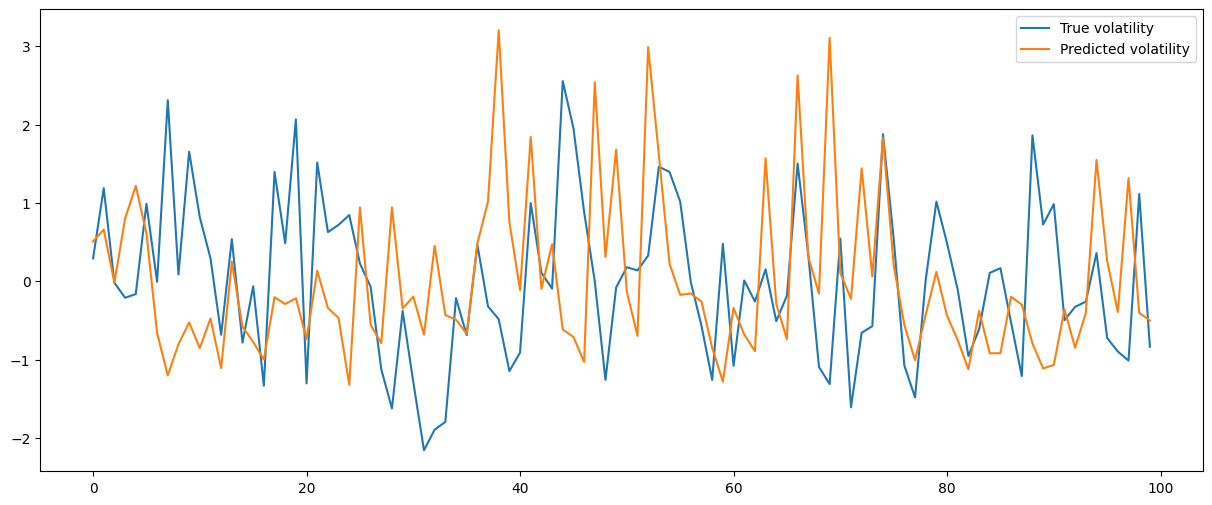

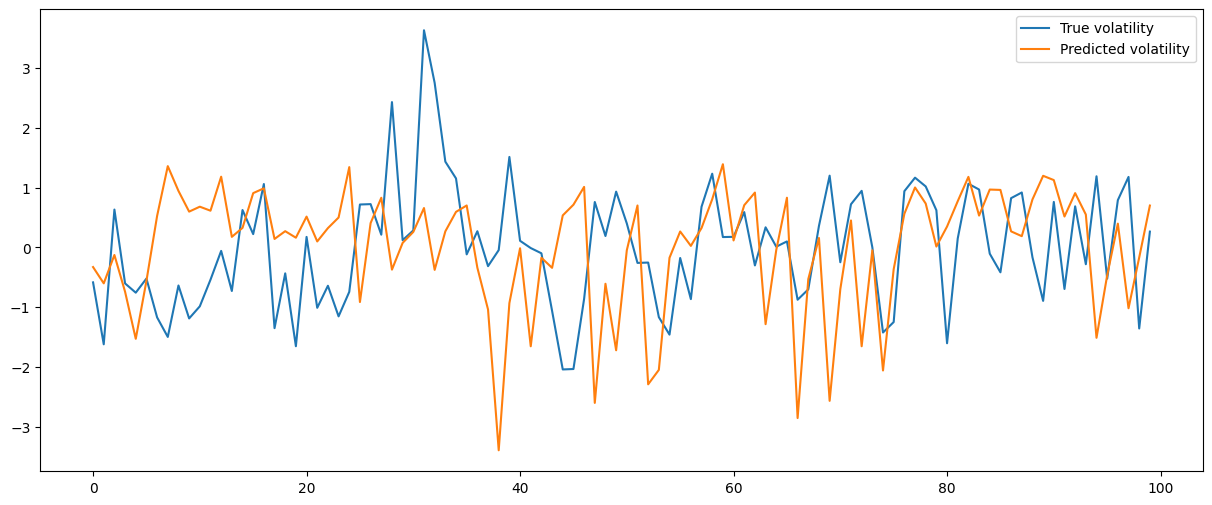

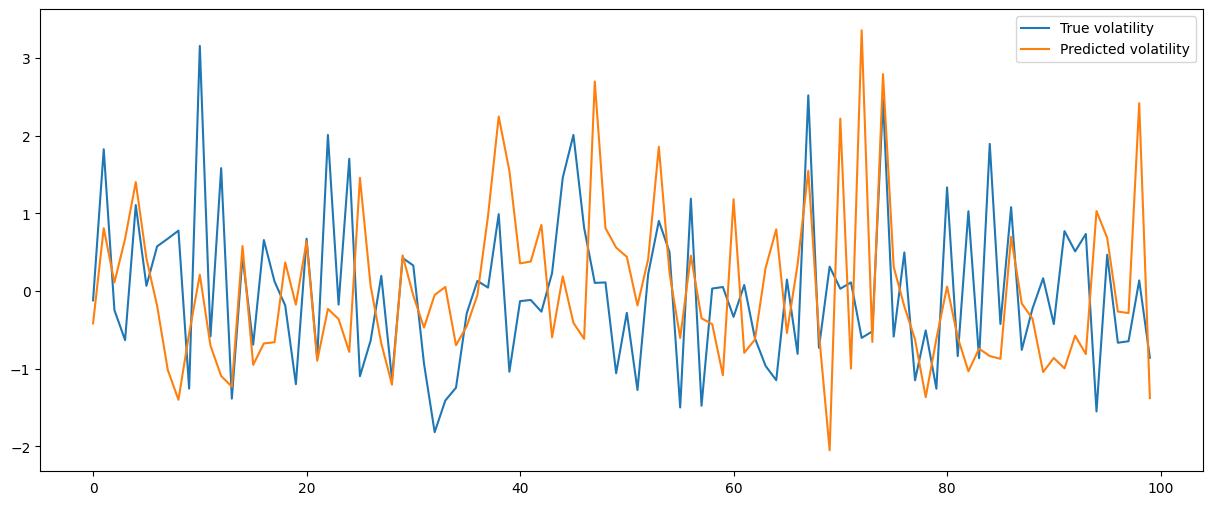

In [22]:
def standardise(x: Array):
    return (x - x.mean()) / x.std() 

for dim in range(S.shape[1]):

    
    plt.figure(figsize=(15, 6))
    plt.plot(standardise(S[:, dim, dim]), label="True volatility")
    plt.plot(standardise(S_hat[:, dim, dim]), label="Predicted volatility")
    plt.legend()
    plt.show()

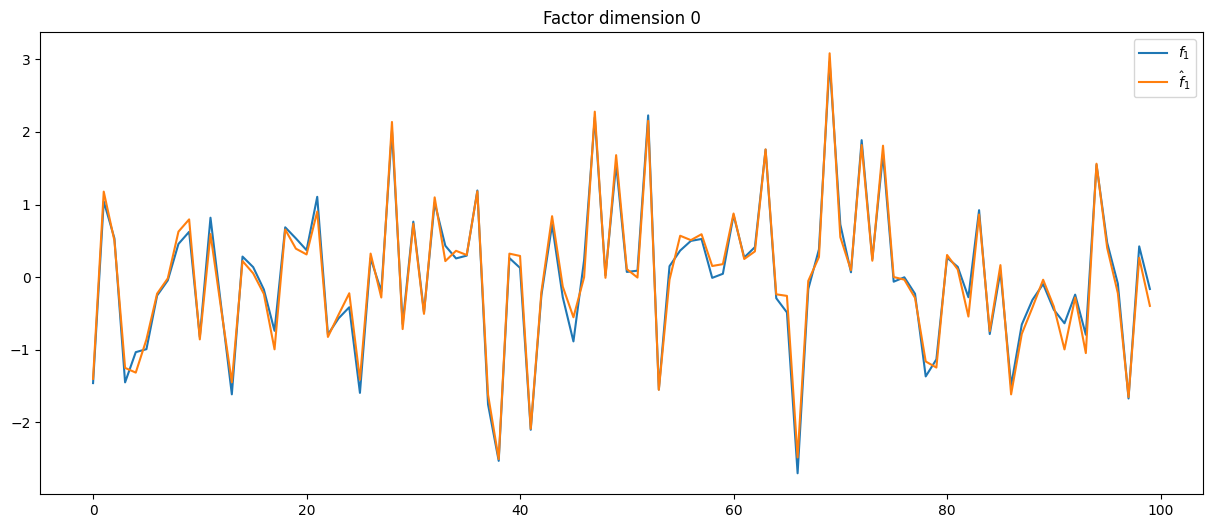

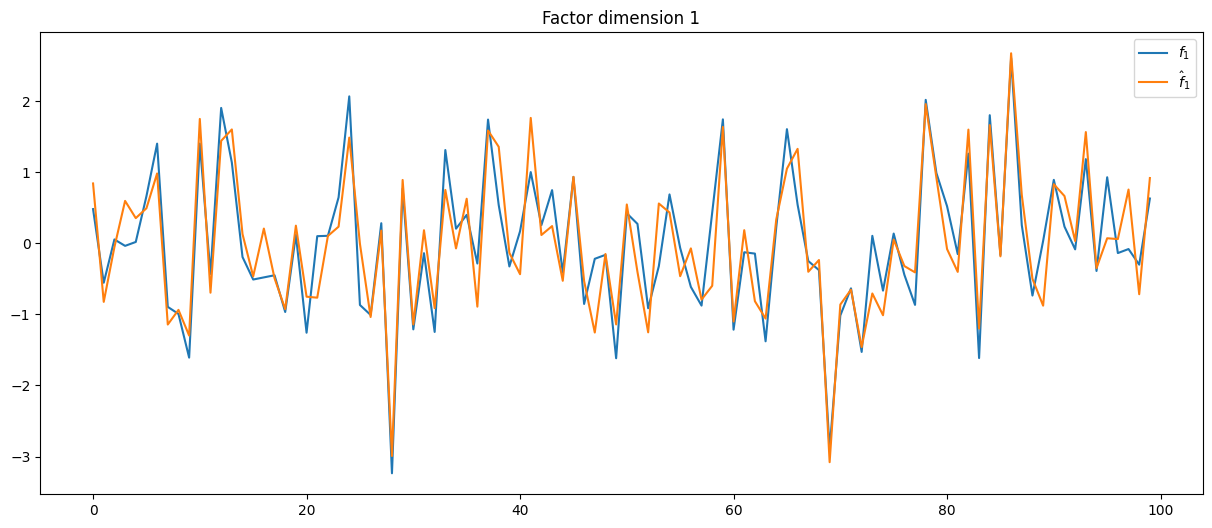

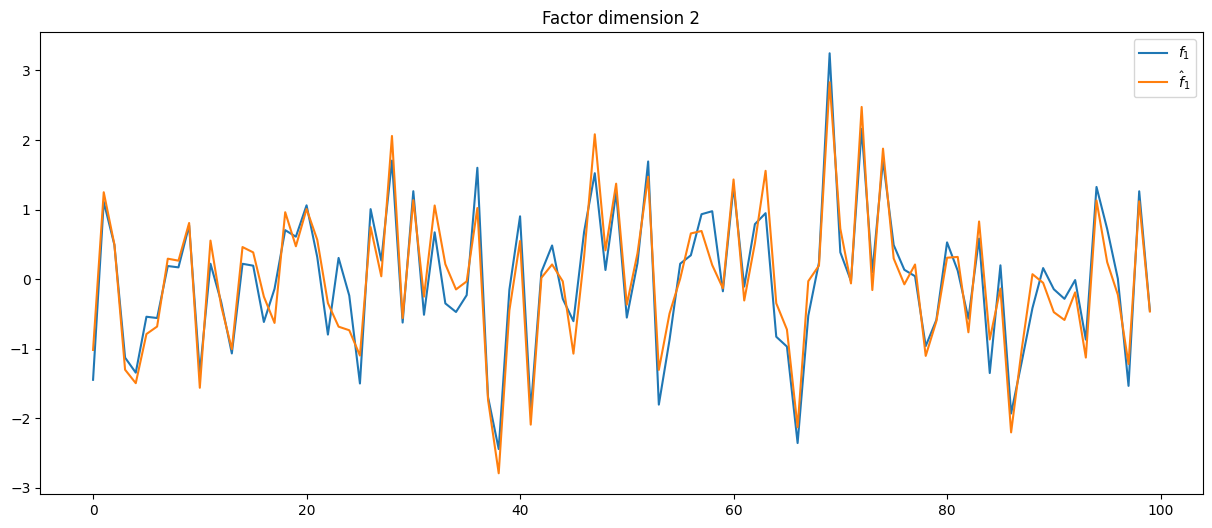

In [14]:
for dim in range(f.shape[1]):
    plt.figure(figsize=(15, 6))
    plt.plot(standardise(f[:, dim]), label="$f_1$")
    plt.plot(standardise(f_hat[:, dim]), label=r"$\hat{f}_1$")
    plt.legend()
    plt.title(f"Factor dimension {dim}")
    plt.show()

In [26]:
h.shape, h_hat.shape

((100, 3), (100, 3))

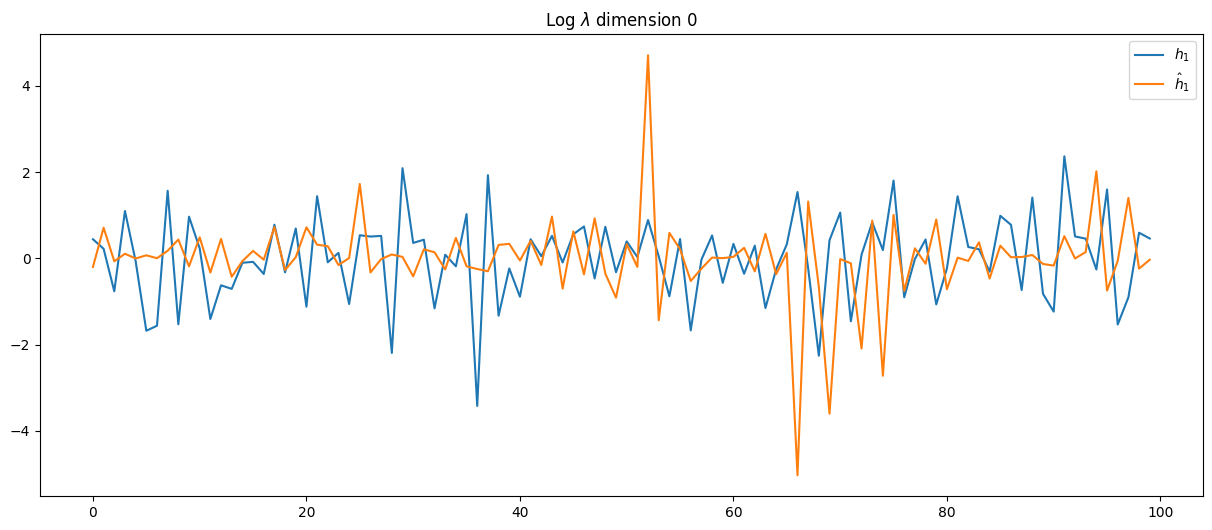

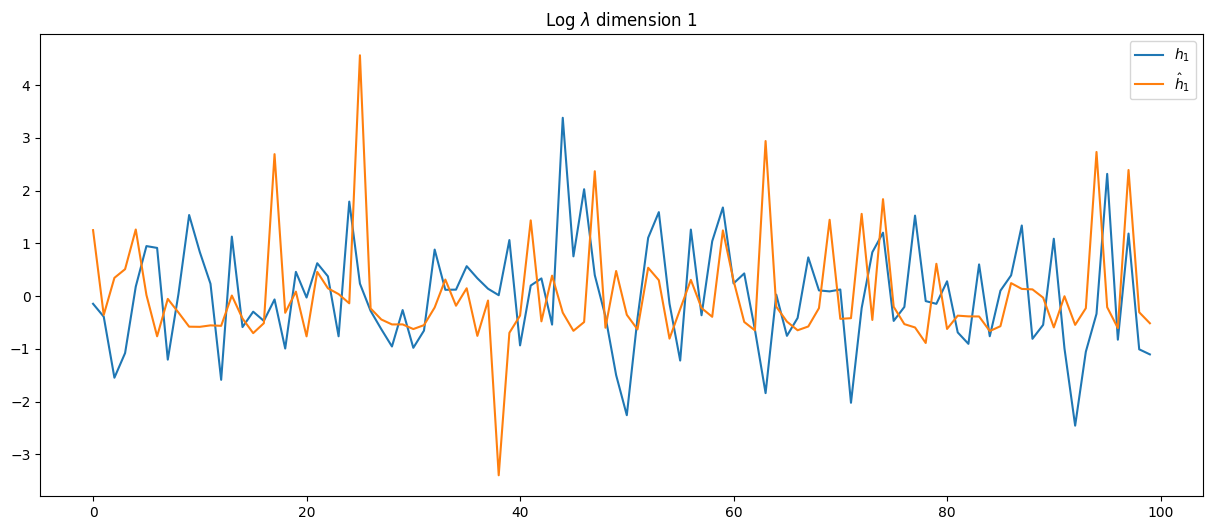

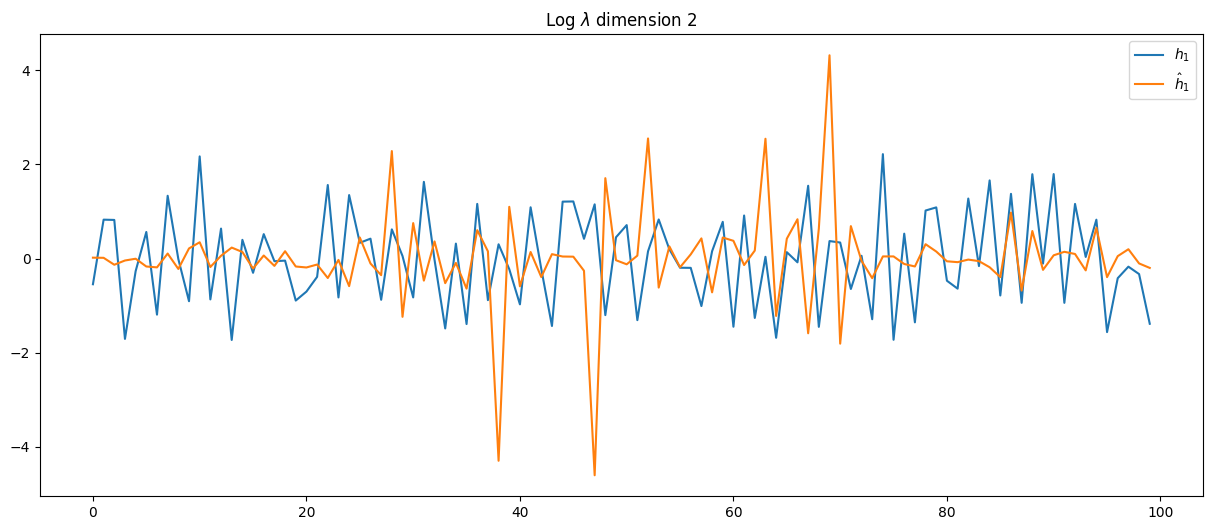

In [15]:
for dim in range(h.shape[1]):
    plt.figure(figsize=(15, 6))
    plt.plot(standardise(h[:, dim]), label="$h_1$")
    plt.plot(standardise(h_hat[:, dim]), label=r"$\hat{h}_1$")
    plt.legend()
    plt.title(rf"Log $\lambda$ dimension {dim}")
    plt.show()

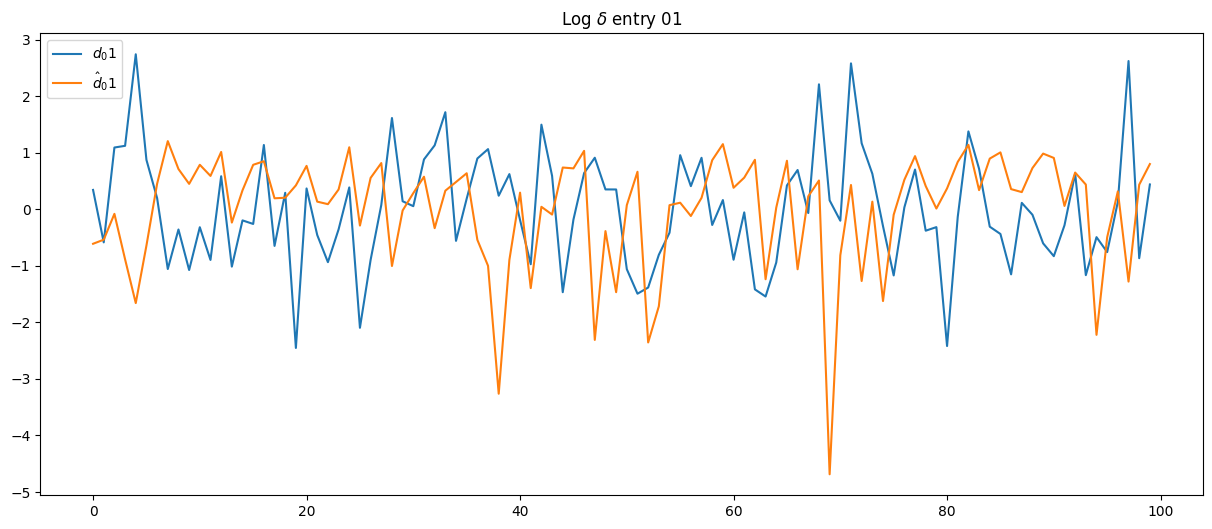

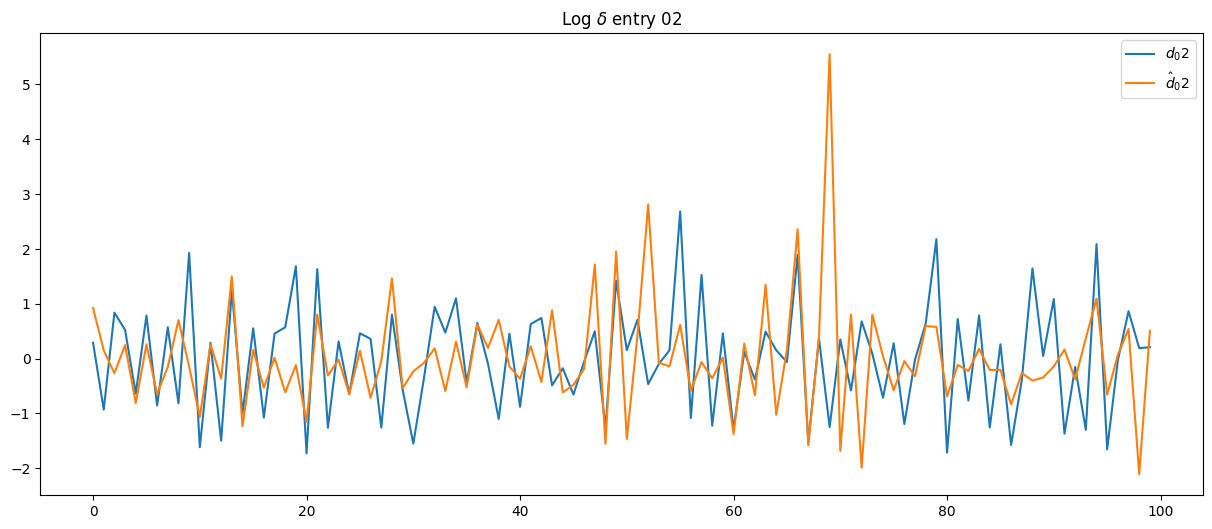

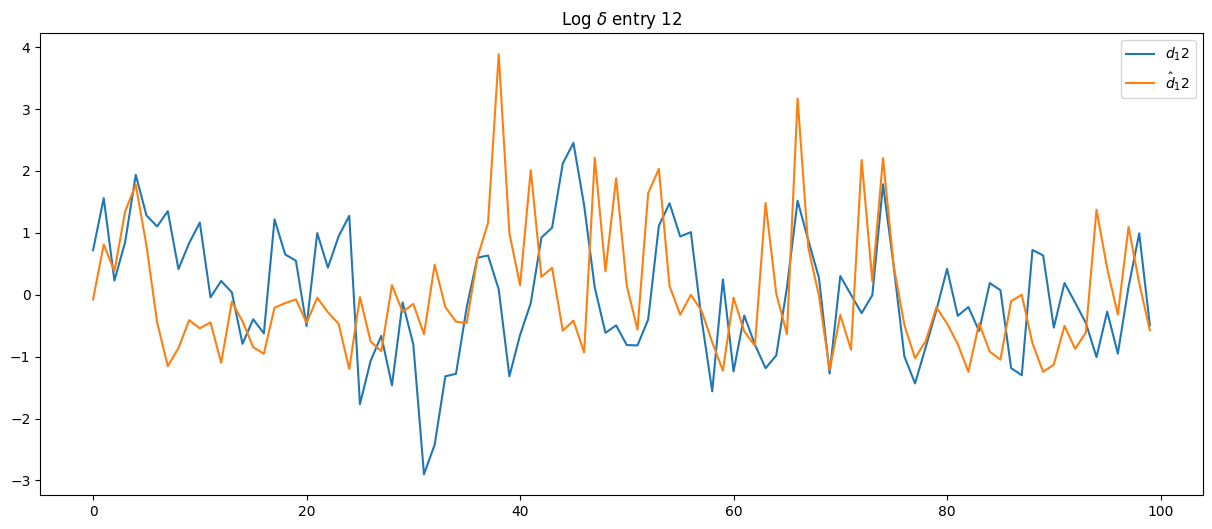

In [16]:
for i in range(d.shape[1]):
    for j in range(d.shape[2]):
        if d[0, i, j] != 0:
                
            plt.figure(figsize=(15, 6))
            plt.plot(standardise(d[:, i, j]), label=f"$d_{i}{j}$")
            plt.plot(standardise(d_hat[:, i, j]), label=r"$\hat{d}_"+f"{i}{j}$")
            plt.legend()
            plt.title(rf"Log $\delta$ entry {i}{j}")
            plt.show()